In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
df = pd.read_csv("data.csv")   # 文件路径可以相对或绝对

In [36]:

def find_latest_stocks(current_df, latest_date):

    # 2. 在最新日期那一天筛选 comprehensive_score 在 10~15 之间
    filtered = df[
        (df['date'] == latest_date) &
        (current_df['comprehensive_score'] >= 25) &
        (current_df['comprehensive_score'] <= 45) &

        # ② 动能必须顺势增强：3日 > 5日 > 10日
        (current_df['comprehensive_score_3_days'] > current_df['comprehensive_score_5_days']) &
        (current_df['comprehensive_score_5_days'] > current_df['comprehensive_score_10_days']) &

        # ③ 不要高潮（避免到达 60–100 的高危区域）
        (current_df['comprehensive_score_20_days'] <= 55) &

        # ④ SMA 趋势明显加强（>15 为强趋势区）
        (current_df['sma_score'] > 15) &

        # ⑤ 价格稳站在 VWAP 上（趋势确认）
        (current_df['vwap_score'] > 5) &

        # ⑥ 资金流向正面（拒绝资金流出）
        (current_df['mfi_score'] >= 0) 

        # ⑦ 大盘行情偏多：避免系统性回调日
        # &(current_df['market_avg_comprehensive_10_days'] > 5) 
    ]

    # 3. 只取 ticker_id 列
    result = filtered['ticker_id'].unique()

    print(result)

    return result

df['date'] = pd.to_datetime(df['date'], format='mixed', dayfirst=True)
latest_date = df['date'].max()
latest_date = '2025-10-29 00:00:00'

result = find_latest_stocks(df, latest_date)

['AMAT' 'APP' 'BAC' 'DOW' 'EBAY' 'GLBE' 'INTC' 'JPM' 'LSCC' 'MRVL' 'SOFI']


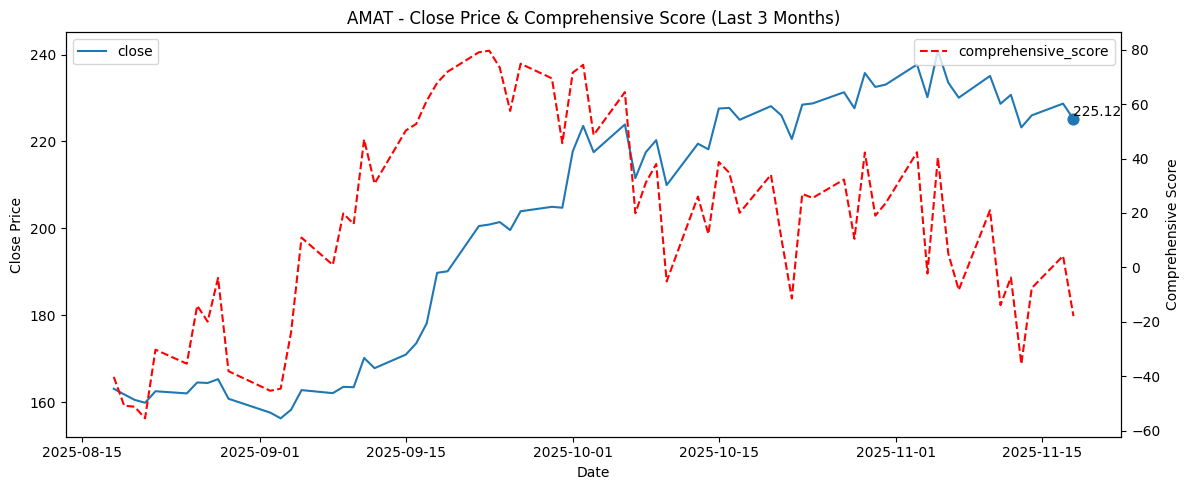

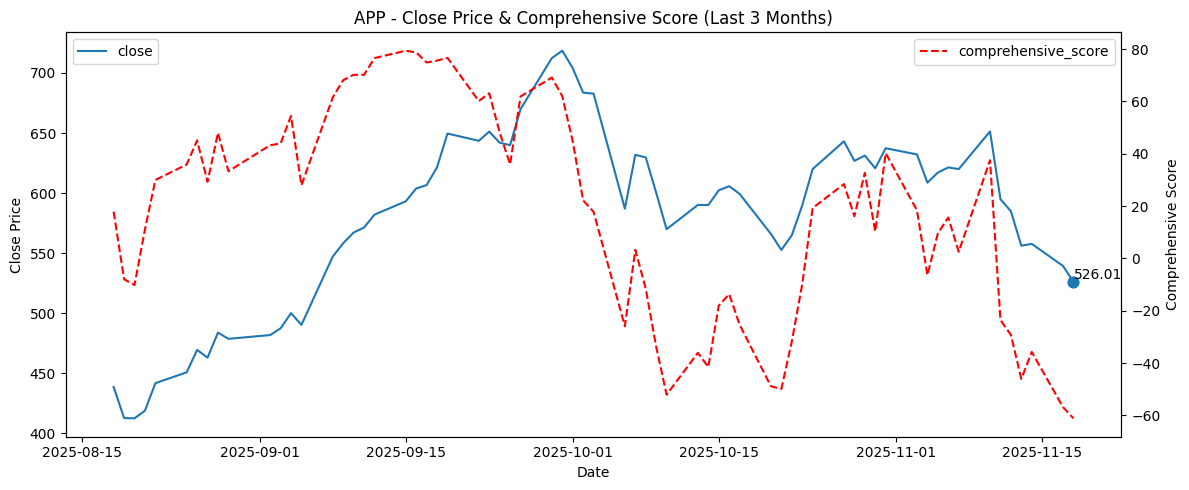

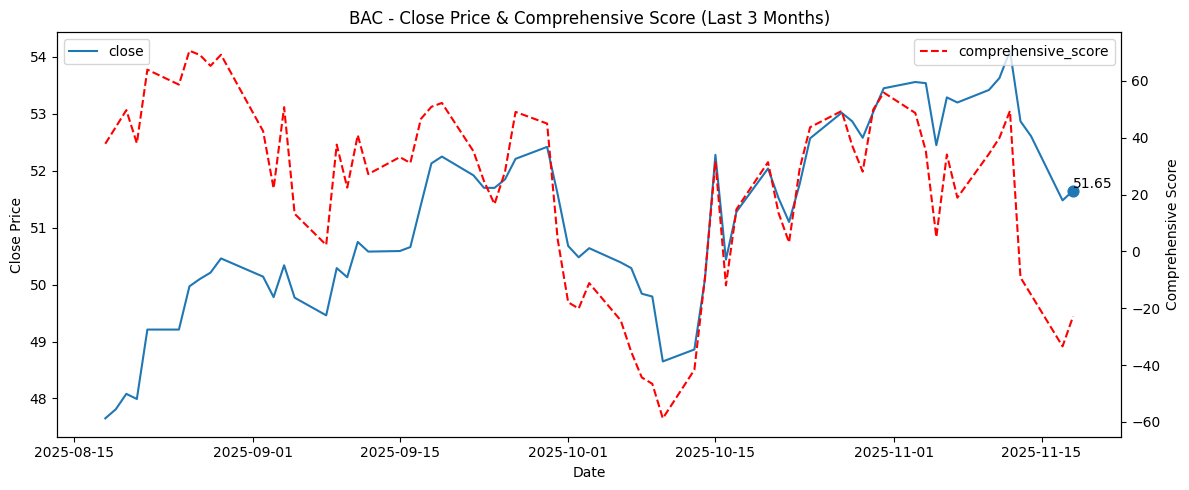

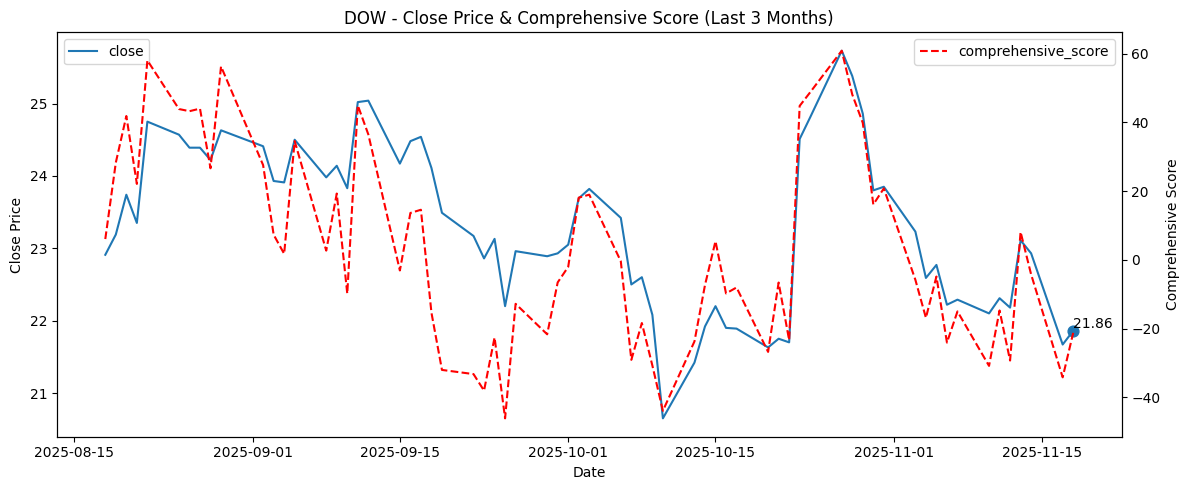

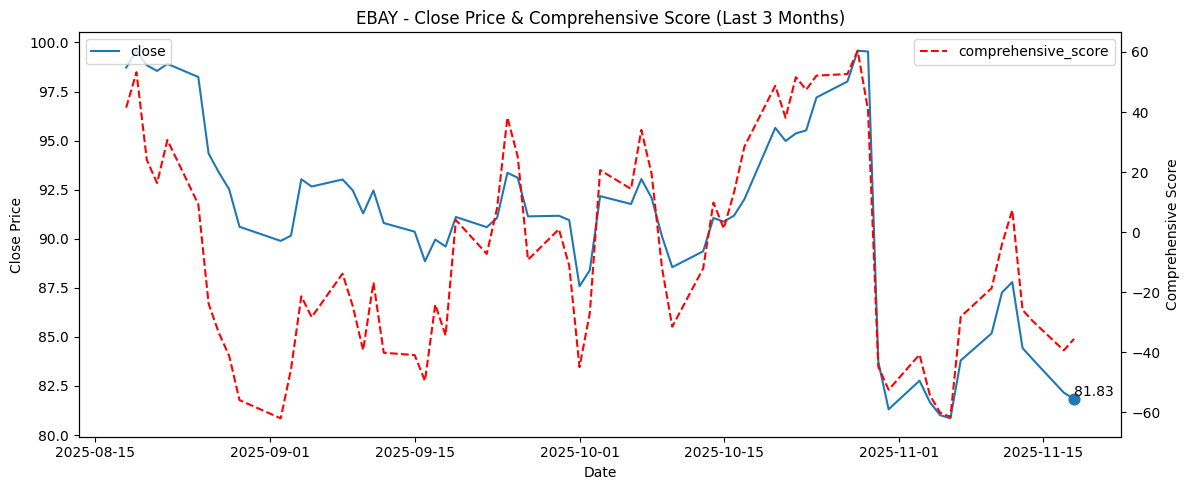

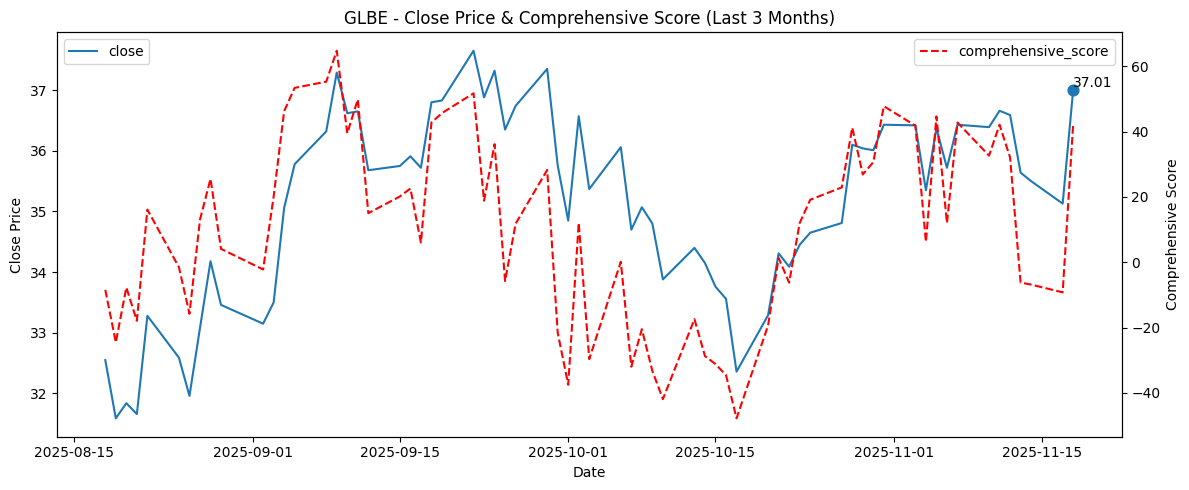

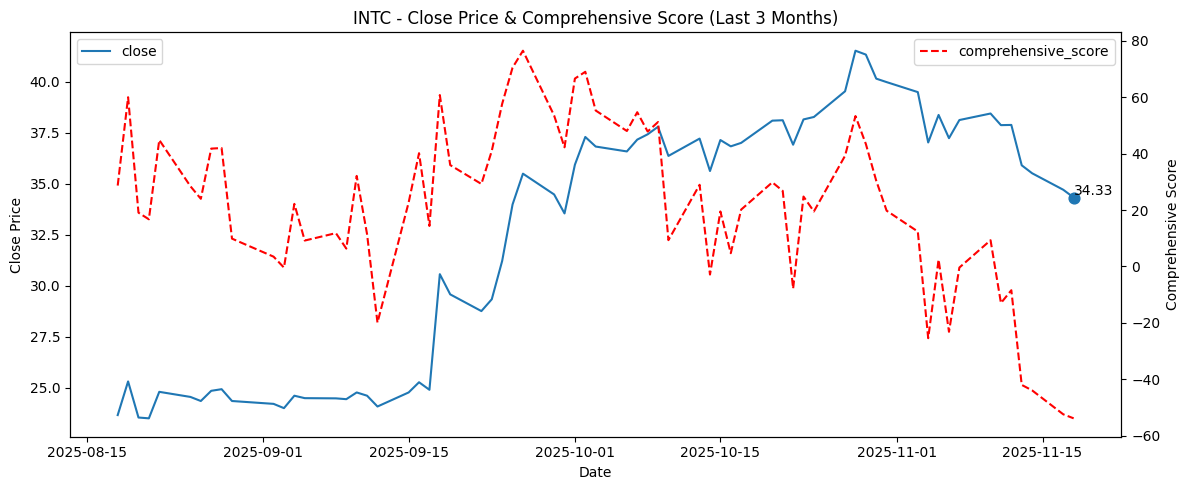

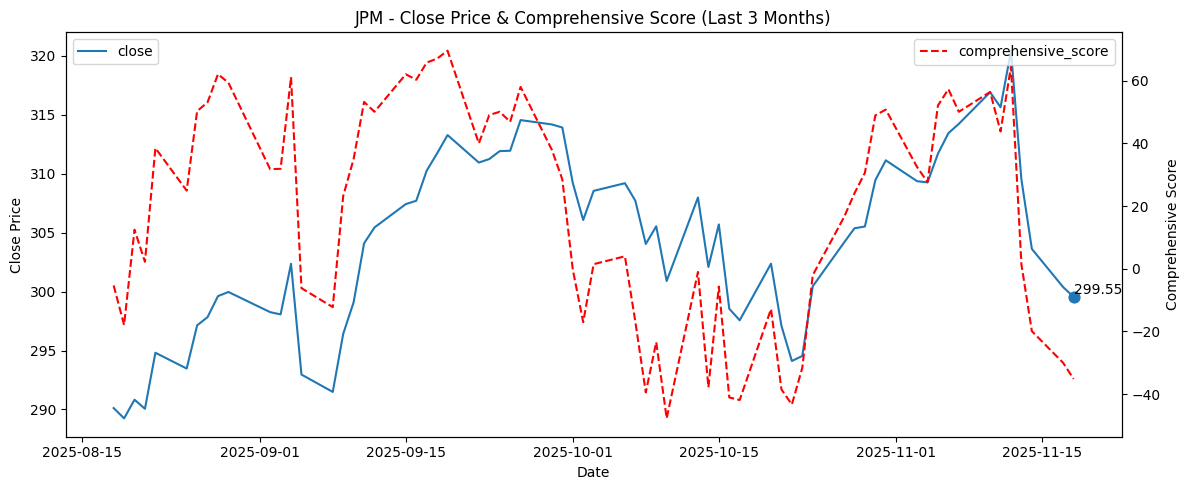

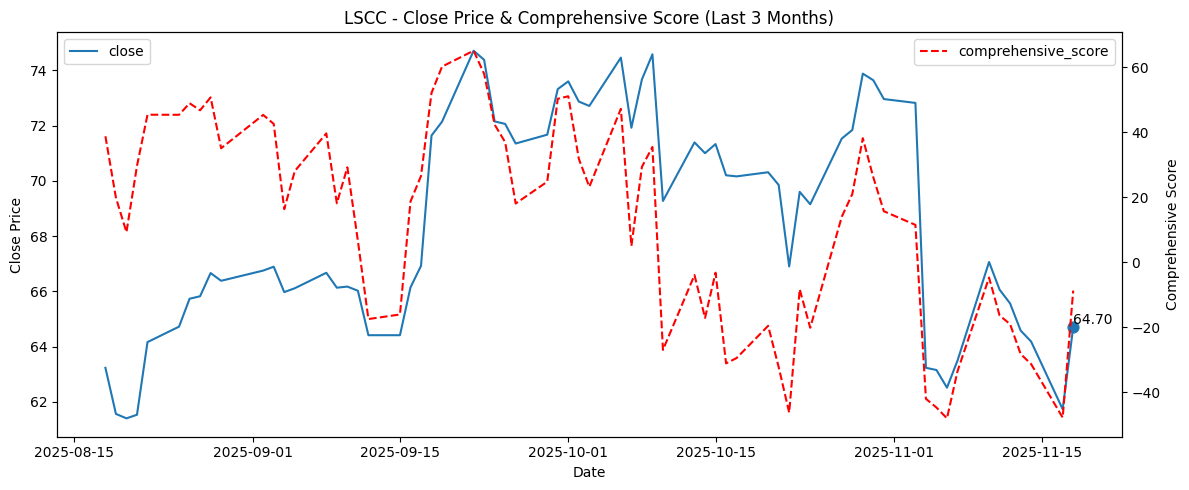

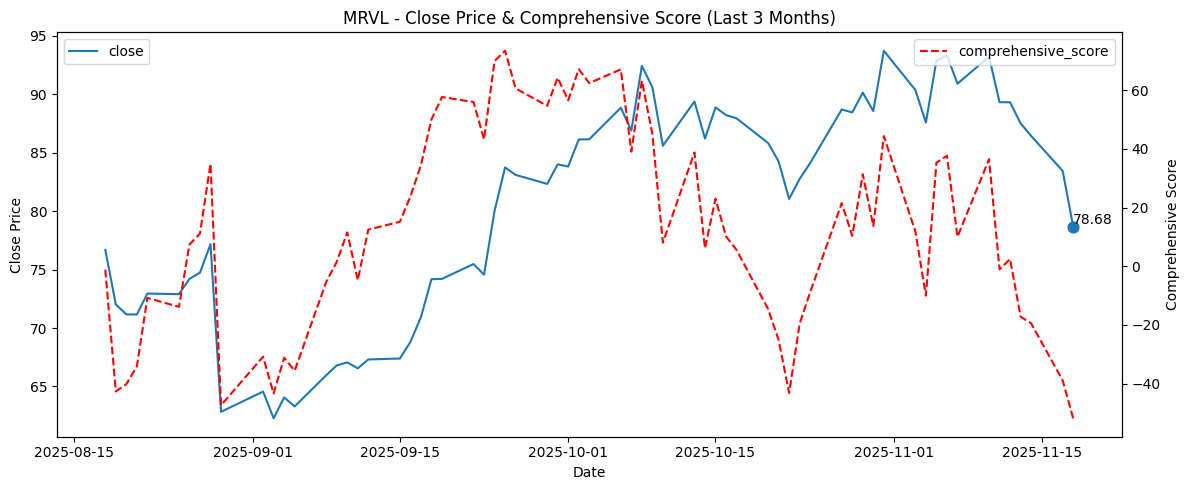

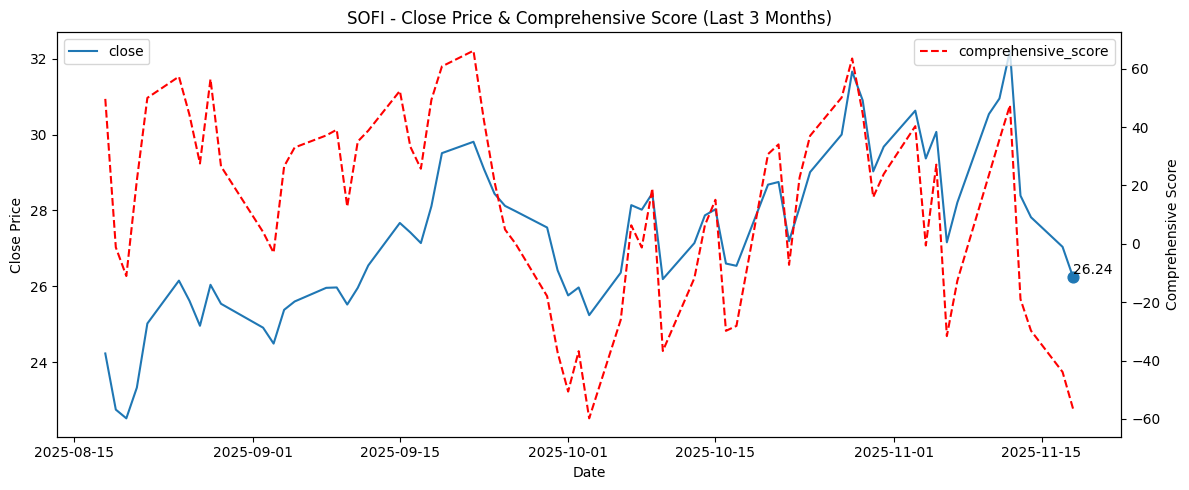

In [37]:
def plot_stock_data(df, result, latest_date):

    # 确保 date 是 datetime 类型
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

    # 只取 result 这些股票的数据
    plot_df = df[df['ticker_id'].isin(result)]

    # 最近 3 个月
    three_months_ago = latest_date - pd.DateOffset(months=3)

    for ticker in result:

        # 过滤数据
        tdf = plot_df[plot_df['ticker_id'] == ticker].copy()
        tdf = tdf[tdf["date"] >= three_months_ago].sort_values("date")

        if tdf.empty:
            continue

        plt.figure(figsize=(12, 5))

        # 画 close
        ax1 = plt.gca()
        ax1.plot(tdf['date'], tdf['close'], label='close')
        ax1.set_xlabel("Date")
        ax1.set_ylabel("Close Price")

        # ⭐ 标出最后一天的 close price
        last_date = tdf['date'].iloc[-1]
        last_close = tdf['close'].iloc[-1]

        ax1.scatter(last_date, last_close, s=60)  # 画点
        ax1.text(
            last_date,
            last_close,
            f"{last_close:.2f}",
            fontsize=10,
            ha='left',
            va='bottom'
        )

        # 画综合评分
        ax2 = ax1.twinx()
        ax2.plot(tdf['date'], tdf['comprehensive_score'],
                 linestyle='--',
                 label='comprehensive_score',
                 color='red')
        ax2.set_ylabel("Comprehensive Score")

        ax1.set_title(f"{ticker} - Close Price & Comprehensive Score (Last 3 Months)")

        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')

        plt.tight_layout()
        plt.show()

latest_date = df['date'].max()
plot_stock_data(df, result, latest_date)
